In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

raw = pd.read_csv("sustainabilityfinal_stacked.csv", na_values=["NA",".."])


In [2]:
long = raw.melt(
    id_vars=["Country Name","Country Code","Series Name","Series Code"],
    var_name="Year",
    value_name="Value"
)

# extract the digits --- reminder -- numeric then drop rows that failed
year_str = long["Year"].str.extract(r"(\d{4})")[0]
long["Year"] = pd.to_numeric(year_str, errors="coerce")
long = long.dropna(subset=["Year"])   # get rid of any non year --- remember that
long["Year"] = long["Year"].astype(int)

long["Value"] = pd.to_numeric(long["Value"], errors="coerce")



In [3]:
wide = long.pivot_table(
    index=["Country Name","Country Code","Year"],
    columns="Series Code", values="Value"
).reset_index()


wide["TARGET"] = (wide["EG.ELC.RNWX.ZS"] >= 30).astype(int)

In [4]:
features = [
  "EG.USE.COMM.FO.ZS",  # fossil share
  "NY.GDP.PCAP.PP.KD",  # GDP / capita PPP
  "SP.URB.TOTL.IN.ZS",  # urban %
  "IT.NET.USER.ZS",     # internet users %
  "AG.LND.FRST.ZS",     # forest %
  "EN.POP.DNST",        # pop density
  "GE.EST","RQ.EST",    # governance & regulation
  "EG.USE.ELEC.KH.PC",  # electricity use
  "EN.GHG.CO2.MT.CE.AR5", # CO2 emissions
  "NV.IND.TOTL.ZS"      # industry % GDP
]


In [5]:
df = wide[["TARGET"] + features].dropna()
print(df.shape, df["TARGET"].value_counts())


(2911, 12) TARGET
0    2795
1     116
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
  df[features], df["TARGET"],
  test_size=0.2, stratify=df["TARGET"], random_state=42
)


In [7]:
logreg = Pipeline([
  ("scaler", StandardScaler()),
  ("clf",    LogisticRegression(max_iter=2000, class_weight="balanced"))
]).fit(X_train, y_train)


In [8]:
grid = GridSearchCV(
  DecisionTreeClassifier(class_weight="balanced",random_state=42),
  {"max_depth":[3,5,7,None],"min_samples_split":[2,5,10]},
  cv=5, scoring="f1"
).fit(X_train, y_train)
tree = grid.best_estimator_


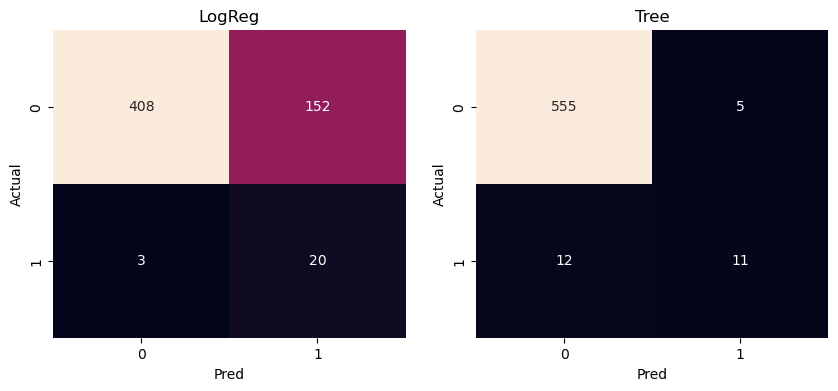

In [9]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
for ax,(name,mdl) in zip(axes,[("LogReg",logreg),("Tree",tree)]):
  cm = confusion_matrix(y_test, mdl.predict(X_test))
  sns.heatmap(cm, annot=True, fmt="d", ax=ax, cbar=False)
  ax.set_title(name); ax.set(xlabel="Pred", ylabel="Actual")



Text(0.5, 1.0, 'Tree importances')

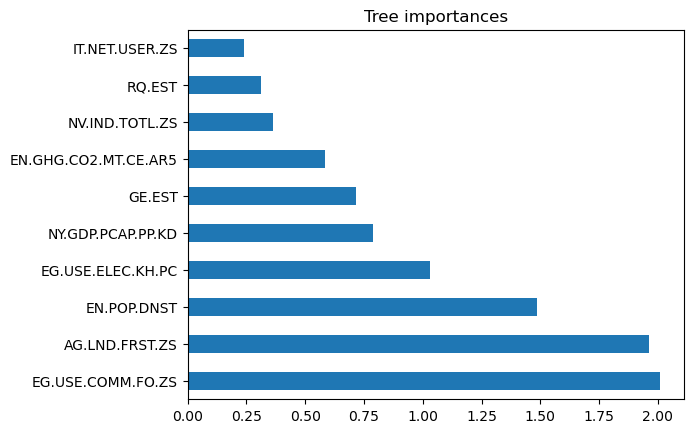

In [10]:
# Logistic coefficients
coefs = pd.Series(logreg.named_steps["clf"].coef_[0], index=features)
coefs.abs().sort_values(ascending=False)[:10].plot.barh(); plt.title("LogReg | Top |coef|")

# Tree importances
imps = pd.Series(tree.feature_importances_, index=features)
imps.sort_values(ascending=False)[:10].plot.barh(); plt.title("Tree importances")


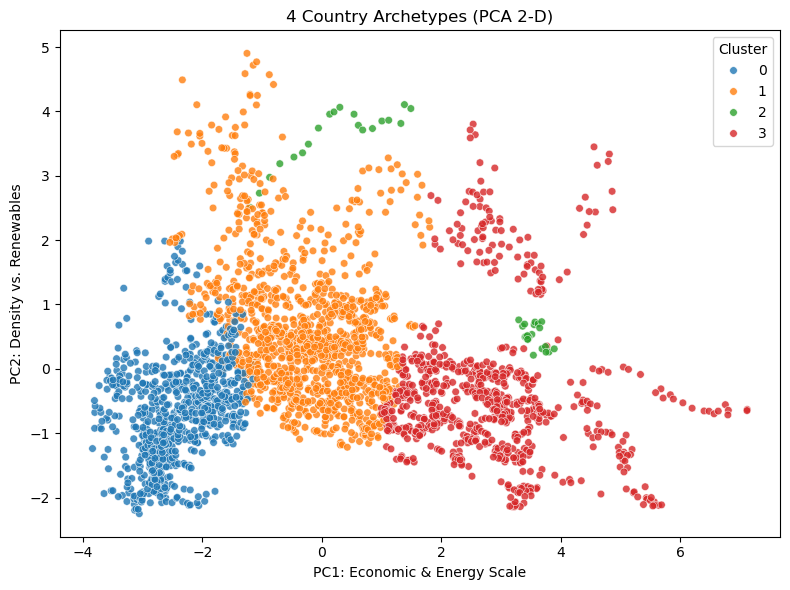

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# scale & cluster
Xs = StandardScaler().fit_transform(df[features])
df["cluster"] = KMeans(n_clusters=4, random_state=42).fit_predict(Xs)

# PCA for 2‐D plotting
pca2 = PCA(n_components=2).fit_transform(Xs)

# scatter with axis annotations
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca2[:,0],
    y=pca2[:,1],
    hue=df["cluster"],
    palette="tab10",
    s=30,
    alpha=0.8
)
plt.title("4 Country Archetypes (PCA 2-D)")
plt.xlabel("PC1: Economic & Energy Scale")
plt.ylabel("PC2: Density vs. Renewables")
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()



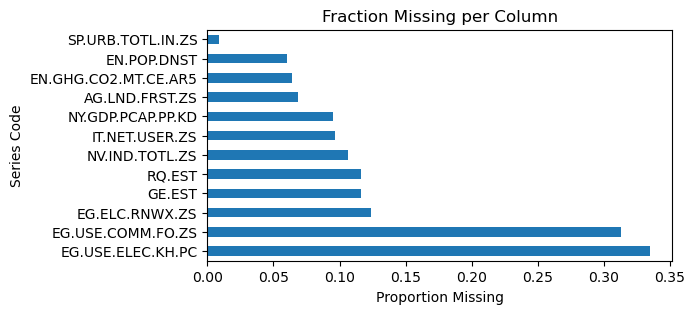

In [12]:
# missing summary for  11 predictors and thedf target
miss = wide[["EG.ELC.RNWX.ZS"] + features].isna().mean().sort_values(ascending=False)
plt.figure(figsize=(6,3))
miss.plot.barh()
plt.title("Fraction Missing per Column")
plt.xlabel("Proportion Missing")
plt.show()


In [13]:
# cvomparisn model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

metrics = []
for name, mdl in [("Logistic Regression", logreg), ("Decision Tree", tree)]:
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)[:,1]
    metrics.append({
        "Model": name,
        "Precision(1)": precision_score(y_test, y_pred),
        "Recall(1)":    recall_score(y_test, y_pred),
        "F1(1)":        f1_score(y_test, y_pred),
        "Accuracy":     accuracy_score(y_test, y_pred),
        "AUC":          roc_auc_score(y_test, y_prob)
    })
metrics_df = pd.DataFrame(metrics).set_index("Model")
metrics_df


Precision(1)  Recall(1)     F1(1)  Accuracy       AUC
Model                                                                     
Logistic Regression      0.116279   0.869565  0.205128  0.734134  0.864829
Decision Tree            0.687500   0.478261  0.564103  0.970840  0.734666

In [14]:
# decison tree grid
print("Best DT params:", grid.best_params_)
cvres = pd.DataFrame(grid.cv_results_)[["params","mean_test_score","std_test_score"]]
cvres.sort_values("mean_test_score", ascending=False).head(5)


Best DT params: {'max_depth': None, 'min_samples_split': 2}


params  mean_test_score  \
9    {'max_depth': None, 'min_samples_split': 2}         0.688309   
10   {'max_depth': None, 'min_samples_split': 5}         0.669435   
11  {'max_depth': None, 'min_samples_split': 10}         0.637910   
7       {'max_depth': 7, 'min_samples_split': 5}         0.362977   
6       {'max_depth': 7, 'min_samples_split': 2}         0.361965   

    std_test_score  
9         0.066296  
10        0.062676  
11        0.063491  
7         0.038433  
6         0.037363

In [15]:
# this is cluster maeans and  PCA variance ratio
cluster_means = df.groupby("cluster")[features].mean().round(2)
print(cluster_means)

from sklearn.decomposition import PCA
Xs = StandardScaler().fit_transform(df[features])
pca = PCA(2).fit(Xs)
print("PCA explained variance ratios:", pca.explained_variance_ratio_)


Series Code  EG.USE.COMM.FO.ZS  NY.GDP.PCAP.PP.KD  SP.URB.TOTL.IN.ZS  \
cluster                                                                
0                        33.04            4557.85              36.37   
1                        82.31           18090.71              64.28   
2                        86.30           37988.75              66.91   
3                        76.36           56756.36              80.53   

Series Code  IT.NET.USER.ZS  AG.LND.FRST.ZS  EN.POP.DNST  GE.EST  RQ.EST  \
cluster                                                                    
0                     10.92           32.73       131.70   -0.81   -0.69   
1                     39.65           30.56       101.02   -0.15   -0.10   
2                     57.59           27.89        87.91    0.90    0.61   
3                     75.89           30.97       411.02    1.33    1.28   

Series Code  EG.USE.ELEC.KH.PC  EN.GHG.CO2.MT.CE.AR5  NV.IND.TOTL.ZS  
cluster                                

In [16]:
#  summary data here
print(f"Data size: {df.shape[0]} rows, {len(features)} predictors, {df['TARGET'].mean()*100:.1f}% positives")
best = metrics_df["F1(1)"].idxmax()
print(f"Best model: {best} (F1={metrics_df.loc[best,'F1(1)']:.2f})")
print("Top feature driving renewables:", coefs.abs().sort_values(ascending=False).index[0])


Data size: 2911 rows, 11 predictors, 4.0% positives
Best model: Decision Tree (F1=0.56)
Top feature driving renewables: RQ.EST


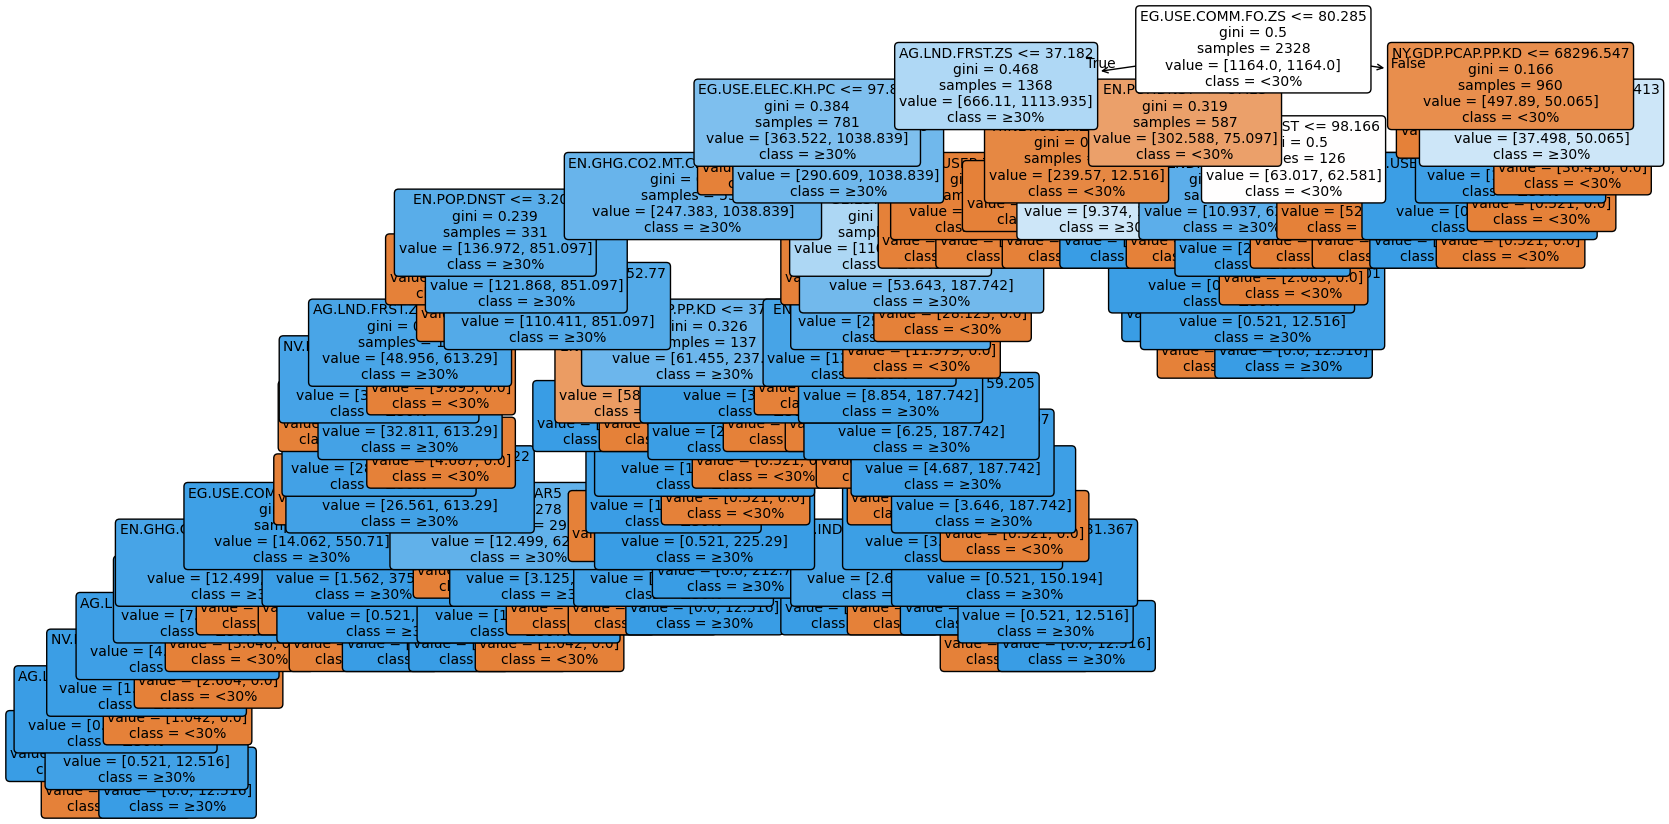

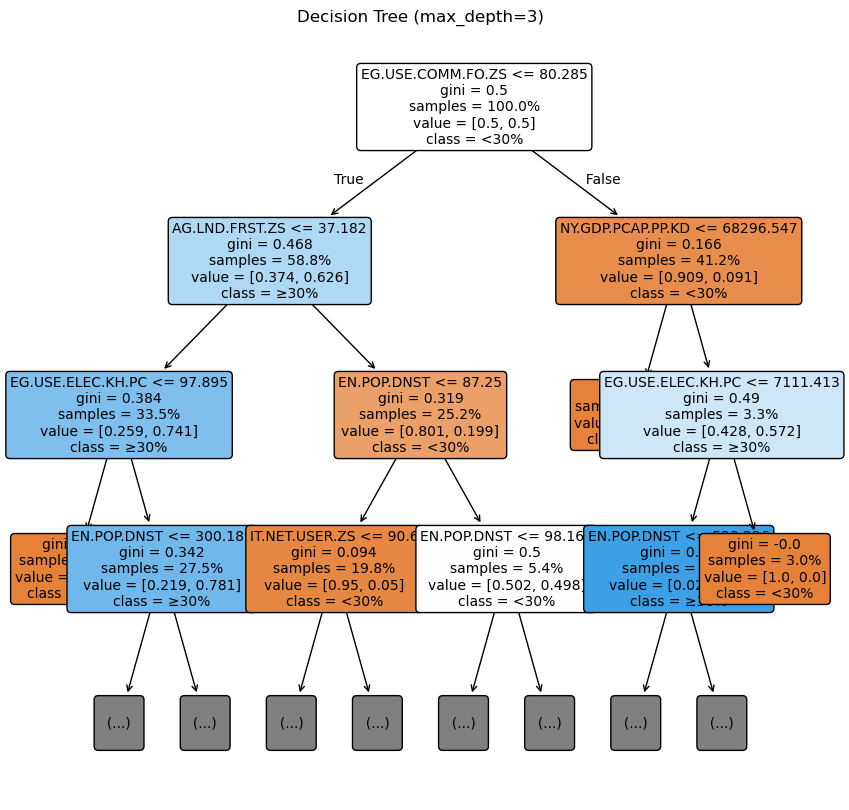

|--- EG.USE.COMM.FO.ZS <= 80.28
|   |--- AG.LND.FRST.ZS <= 37.18
|   |   |--- EG.USE.ELEC.KH.PC <= 97.89
|   |   |   |--- class: 0
|   |   |--- EG.USE.ELEC.KH.PC >  97.89
|   |   |   |--- EN.POP.DNST <= 300.19
|   |   |   |   |--- EN.GHG.CO2.MT.CE.AR5 <= 40.56
|   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |--- EN.GHG.CO2.MT.CE.AR5 >  40.56
|   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- EN.POP.DNST >  300.19
|   |   |   |   |--- IT.NET.USER.ZS <= 0.11
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- IT.NET.USER.ZS >  0.11
|   |   |   |   |   |--- class: 0
|   |--- AG.LND.FRST.ZS >  37.18
|   |   |--- EN.POP.DNST <= 87.25
|   |   |   |--- IT.NET.USER.ZS <= 90.60
|   |   |   |   |--- class: 0
|   |   |   |--- IT.NET.USER.ZS >  90.60
|   |   |   |   |--- EN.POP.DNST <= 30.71
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- EN.POP.DNST >  30.71
|   |   |   |   |   |--- class: 1
|   |   |--- EN.POP.DNST >  87.25
|   |   |   |--- EN.

In [17]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    tree,
    feature_names=features,
    class_names=["<30%","≥30%"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plot_tree(
    tree,
    feature_names=features,
    class_names=["<30%","≥30%"],
    filled=True,
    rounded=True,
    max_depth=3,         # only show the first 3 splits
    proportion=True,     # node widts
    fontsize=10
)
plt.title("Decision Tree (max_depth=3)"); 
plt.show()

from sklearn.tree import export_text

txt = export_text(
    tree,
    feature_names=features,
    max_depth=4          # adjust depth to control length
)
print(txt)




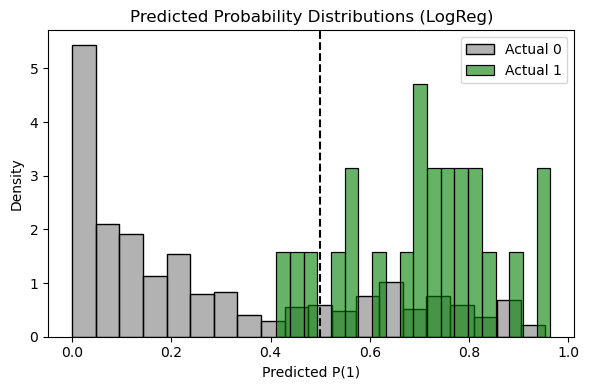

In [18]:
probs = logreg.predict_proba(X_test)[:,1]
plt.figure(figsize=(6,4))
sns.histplot(probs[y_test==0], color="gray", label="Actual 0", stat="density", bins=20, alpha=0.6)
sns.histplot(probs[y_test==1], color="green", label="Actual 1", stat="density", bins=20, alpha=0.6)
plt.axvline(0.5, color="black", linestyle="--")
plt.title("Predicted Probability Distributions (LogReg)")
plt.xlabel("Predicted P(1)")
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

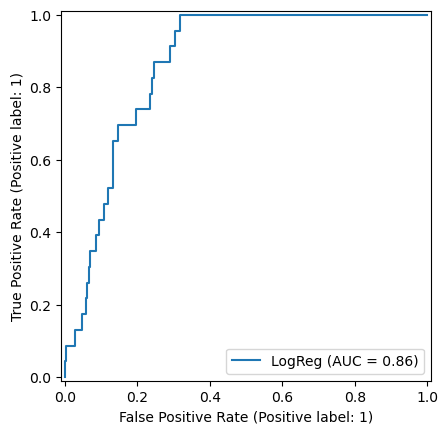

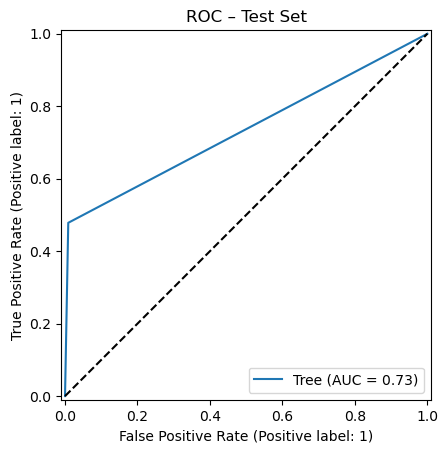

<Figure size 600x600 with 0 Axes>

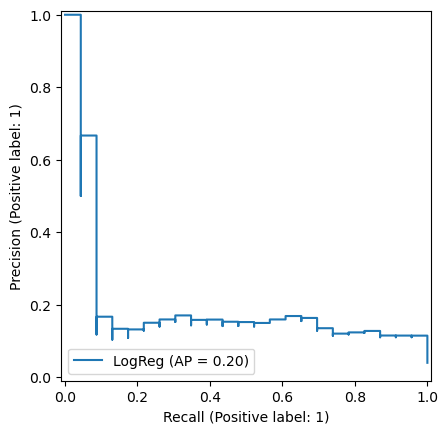

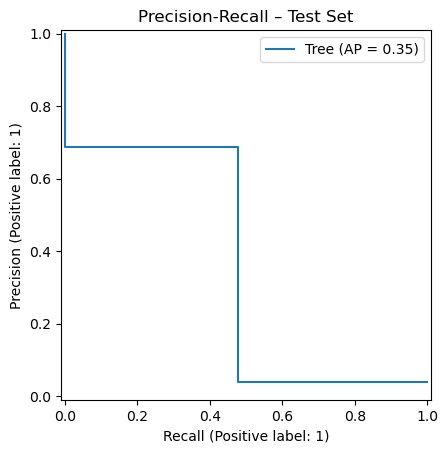

In [19]:
# curves roc (unified) and precision recall (help understand)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

plt.figure(figsize=(6,6))
RocCurveDisplay.from_estimator(logreg, X_test, y_test, name="LogReg")
RocCurveDisplay.from_estimator(tree,   X_test, y_test, name="Tree")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC – Test Set")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(6,6))
PrecisionRecallDisplay.from_estimator(logreg, X_test, y_test, name="LogReg")
PrecisionRecallDisplay.from_estimator(tree,   X_test, y_test, name="Tree")
plt.title("Precision-Recall – Test Set")
plt.legend(loc="upper right")
plt.show()